### GEOG0051

Mining Social and Geographic Datasets
-----------------------------------

Machine Learning Analysis with Venue Review Data in Calgary, Canada
-------------------------------

Stephen Law, Igor Tkalec, Thomas Keel, and Gong Jie

For this second task, we would like you to analyse a dataset that contains review data of different venues in the city of Calgary,
Canada. With the help of several machine learning techniques that we have learnt in the course, you will be tasked to distill
insights from this social media dataset. Two of its notable features are the geocoding of every reviewed venues and the
availability of a considerable amount of text data in it, which lend to its ability to be processed using spatial and text analysis
techniques respectively.

As a prelude to the analysis prompts below, have a brief think about some of these questions: What can we discover about the
venue review data? Are there any spatial patterns that can be extracted from the data? Can we build a machine learning model
that predicts review rating for unseen data points using the text of the reviews?

### 3.1 Format of Data

The variables contained in the dataset provided in the `Calgary.csv` file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `review_count` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `review_id` unique identifier of the review <br/>
* `user_id` unique identifier of the individual who left the review<br/>
* `stars_y` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, i.e. tags that the user attached to the review<br/>
* `text`, text of the review <br/>
* `date` i.e. the date of the review<br/>

### 3.2.1 Loading and cleaning the textual dataset


#### 3.2.1.1 Loading the data


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack




nltk.download('stopwords')
nltk.download('wordnet')
  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = pd.read_csv('Calgary.csv')

#### 3.2.1.3 Positive/Negative Variable


Even though this step is not mentioned until 3.2.2, it is interesting to see the distribution of this variable alongside the other variables in the next step.

In [7]:
data['positive'] = data['stars_y'].apply(lambda x: 1 if x >= 4 else 0)
data

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52,1
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06,1
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38,1
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25,1
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",pd7i8sxkMfbjdWR926nz8Q,zYLF37lcx2MPIHZVJjahBA,5.0,1,1,0,"I rarely post reviews, but wanted to express h...",2016-08-18 14:19:05,1
82178,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",Uu4txscaQB25tF5kuG4gkg,rlY-ah6vhTHiRkJMEtDJ-g,5.0,1,0,0,I used Martin's Pest Control for an under-conc...,2015-10-17 23:16:52,1
82179,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",kooH5UmJ5k-8USDe03jI9Q,Id5k4kNeblkyQSuteVURGQ,1.0,6,0,0,"This company came into my home, 'inspected' th...",2011-09-09 20:22:04,0
82180,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",2SUoFTckEOdGd1V7GpIvrg,grsdpOuwSdwN3ndafhfa9Q,1.0,3,0,0,I would never recommend them to anyone. I pur...,2013-08-02 07:21:12,0


#### 3.2.1.4 Describing numeric variables and checking distribution of these attributes


In [8]:
data.describe()

,latitude,longitude,review_count,stars_y,useful,funny,cool,positive
count,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000
mean,51.042724,-114.070648,61.995254,3.618639,1.293203,0.391083,0.382578,0.640262
std,0.051552,0.053040,77.290191,1.424214,2.830347,1.306604,1.171075,0.479926
min,50.865169,-114.379523,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,51.033200,-114.086896,13.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,51.044727,-114.070254,36.000000,4.000000,0.000000,0.000000,0.000000,1.000000
75%,51.066428,-114.053056,78.000000,5.000000,2.000000,0.000000,0.000000,1.000000
max,51.207540,-113.714140,512.000000,5.000000,104.000000,59.000000,69.000000,1.000000


Checking the distribution of latitude and longitude doesn't give us any information. Therefore we exclude those attributes from our plotting stage.

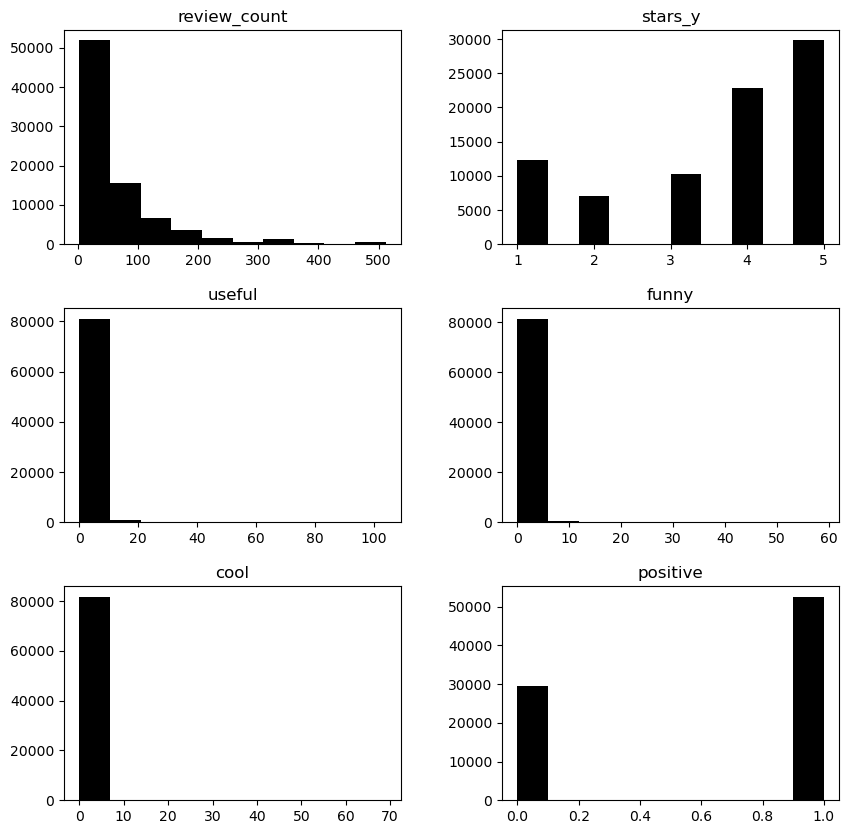

In [9]:
numeric_cols = ['review_count','stars_y', 'useful', 'funny', 'cool', 'positive']
numeric_data = data[numeric_cols]
numeric_data.hist(figsize=(10,10),color='black',grid=False)
#plt.axis(False)
plt.show()

#### 3.2.1.5 Discovering categorical variables


In [10]:
categorical_data = data.select_dtypes(include=[object])
categorical_data.columns

Index(['business_id', 'name', 'categories', 'hours', 'review_id', 'user_id',
       'text', 'date'],
      dtype='object')

We observe how business categories are inputted in the data for our future analysis

#### 3.2.1.6 Pre-process text reviews

We define a function to pre-process our text column. 
This function 
* removes punctuation and numbers, 
* turns words into lowercase, 
* tokenizes them, 
* removes stopwords, 
* lemmatizes the tokens
* joins the tokes back into a string.
At the end, we join this new pre-processed text as a new column to our data.

In [12]:
# Define a function for text preprocessing
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    
    #Lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token.lower() in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text
data['preprocessed_text'] = data['text'].apply(preprocess_text)

### 3.2.2 Build a supervised learning for text analysis


#### 3.2.2.1 Models with only text 

We are definig the vectorizer that is going to be used in the model. Since we already have a column of cleaned data, we do not include a text cleaning process into this vectoriser.

This vectorizer removes the words that occur in more that 95% of the observations and less than 1% of the observations. This helps us remove words are too frequent too infrequent to be relevant to help our model classify observations.

We visualise the output of this vectorizer. 

In [77]:
text_column = data['preprocessed_text'].tolist()
#turns text data into feature vectors
vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=0.01)

#check how it looks
text_column_transformed = vectorizer.fit_transform(text_column)
pd.DataFrame(text_column_transformed.toarray(),columns=[vectorizer.get_feature_names_out()])

,able,absolutely,accommodating,across,actually,add,added,addition,afternoon,ago,...,wrong,year,yelp,yes,yet,youll,young,youre,youve,yummy
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82180,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


However, there can be an even better way to vectorize our text data. We define a term frequency - inverse document frequency vectorizer (this improves the accuracy of our models).

In [165]:
#turns text data into feature vectors
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, 
                                    min_df=0.01)

#check how it looks
text_column_tfidf = tfidf_vectorizer.fit_transform(text_column)
pd.DataFrame(text_column_tfidf.toarray(),columns=[tfidf_vectorizer.get_feature_names_out()])
    

,able,absolutely,accommodating,across,actually,add,added,addition,afternoon,ago,...,wrong,year,yelp,yes,yet,youll,young,youre,youve,yummy
0,0.13344,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.00000,0.0,0.161639,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.102862,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,0.00000,0.0,0.0,0.0,0.13952,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
82178,0.00000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
82179,0.00000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
82180,0.00000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.225047,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


We test and train split our data. Our predictor is the preprocessed text and our target categories are positive and negative.

We apply a 10% test size. Then, we apply our vectorizer to the text train and text test sets. 

In [227]:
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.10, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


We define a function to print out necessary statistics (f1 score, accuracy score, mse, and r2) and visualisations for us to evaluate the model performance.

In [225]:
def printStats(y_test, y_pred):
    # y_test contains the true ratings and y_pred contains the predicted ratings
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
  
    print("MSE:", mse)
    print("R2-score:", r2)
   
        
    print ("F1 score:", f1_score(y_test, y_pred, average='macro'))
    print ("Accuracy:", accuracy_score(y_test, y_pred)) 
    
    #creates a grid to plot on
    f, ax = plt.subplots(figsize=(7, 5))
    #plots confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.show()

We fit our classifiers:
* Naive Bayes Classifier
* Logistic Regression Classifier
* Random Forest Classifier 
Disclaimer: Random Forest Classifier may take more time than the others. 

MSE: 0.19138581335928945
R2-score: 0.1769230994502755
F1 score: 0.7659828566092428
Accuracy: 0.8086141866407105


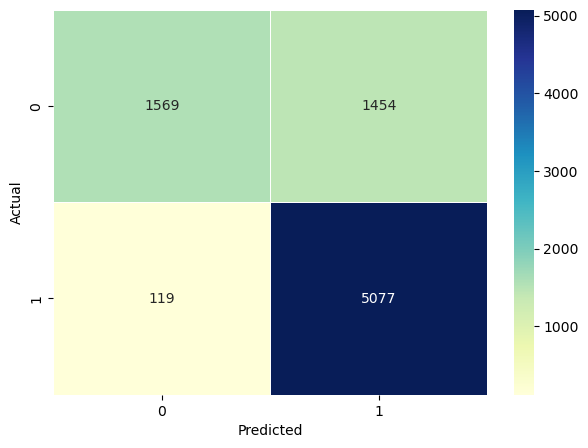

In [228]:
# Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(x_train_vectors, y_train)

# this uses the Naive Bayes Classifier to predict
y_pred = clf.predict(x_test_vectors)
printStats(y_test, y_pred)

MSE: 0.11449081396763597
R2-score: 0.5076189679483212
F1 score: 0.8745030088383282
Accuracy: 0.8855091860323641


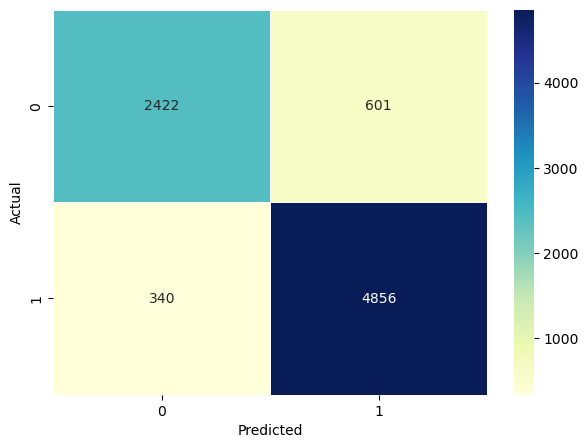

In [229]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

At some point, our logistic regression doesn't converge. We increase the maximum iteration to fix this. 

MSE: 0.15464168390315122
R2-score: 0.3349454923085188
F1 score: 0.8276278592321413
Accuracy: 0.8453583160968487


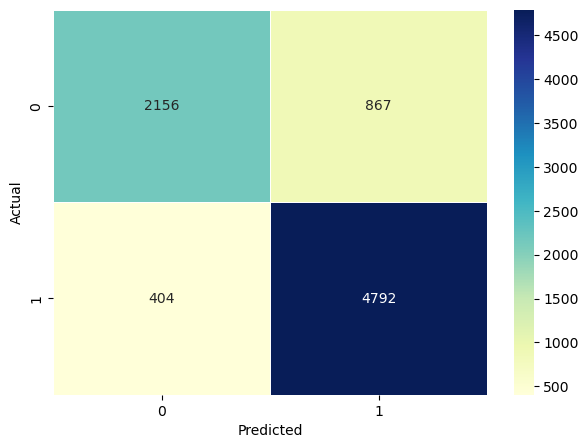

In [25]:
# Random Forest Classifier

# create an instance of the Random Forest Classifier
clf_forest = RandomForestClassifier(n_estimators=300, random_state=1)

# fit the classifier on the training data
clf_forest.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_forest.predict(x_test_vectors)
printStats(y_test, y_pred)

#### 3.2.2.2 Models with text and non-text features

We write a function to add non-text features to add to our model. 

In [230]:
# Takes a matrix of new features
def addFeatures(x_train_vectors, x_test_vectors, train_features, test_features):
    return (hstack((x_train_vectors, train_features)), 
            hstack((x_test_vectors, test_features)))


feature_cols = ["cool", "funny", "useful", "latitude", "longitude", "review_count"]
x_train_vectors, x_test_vectors = addFeatures(x_train_vectors, x_test_vectors,
                                             x_train[feature_cols].to_numpy(), 
                                             x_test[feature_cols].to_numpy())

Logistic regression is the best performing classifier among the three, therefore we use that to compare model outputs before and after adding these new features. 

MSE: 0.11400413675629639
R2-score: 0.5097119797742582
F1 score: 0.8750167179599618
Accuracy: 0.8859958632437036


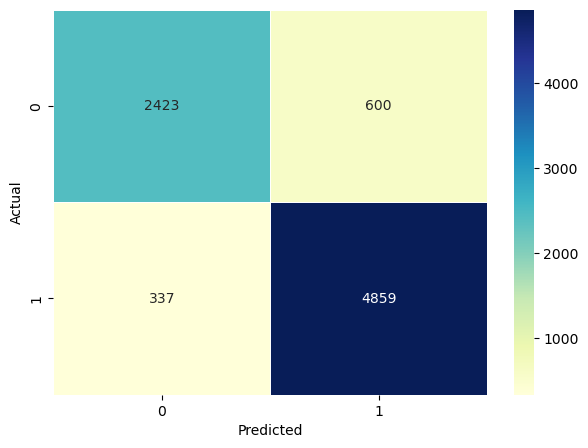

In [231]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_feature = clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

In [215]:
# Train the logistic regression model
clf = LogisticRegression(max_iter=10000).fit(x_train_vectors, y_train)

# Extract the coefficient estimates for the additional features
additional_features_coef = clf.coef_[0][-len(feature_cols):]

# Create a dataframe to display the feature importance
importance_df = pd.DataFrame({'feature': feature_cols, 
                              'importance': additional_features_coef})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

     feature  importance
0   latitude    0.602296
1  longitude    0.268739


#### 3.2.2.3 Models applied on subset of Vietnamese restaurants

In [121]:
categories_list = data['categories'].tolist()
cat = pd.DataFrame(categories_list, columns=['categories'])

#number of unique categories
print(len(set(categories_list)))



3861


There are 3861 unique "bunch" of categories in this data. We note that this doesn't mean that there are 3861 different category attributes but means that there are 3861 unique combination of these categories.

In [122]:
value_counts = cat.value_counts().head(10).reset_index(name="count")
value_counts

,categories,count
0,"Restaurants, Breakfast & Brunch",1085
1,"Vietnamese, Restaurants",912
2,"Restaurants, Vietnamese",729
3,"Restaurants, Pizza",653
4,"Pizza, Restaurants",469
5,"Sushi Bars, Japanese, Restaurants",463
6,"Restaurants, Steakhouses",459
7,"Canadian (New), Restaurants",435
8,"Chinese, Restaurants",400
9,"Italian, Restaurants",398


Vietnamise restaurants, under two differently ordered but same categories, are the most frequently mentioned (1641 times) category. We subset them to apply the model.

In [123]:
viet = data[(data['categories'] == 'Vietnamese, Restaurants') | (data['categories'] == 'Restaurants, Vietnamese')]
viet

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text
1673,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",38C7g-G4tlXTzUUYCebgBw,uJTi6gG31LQw1Im5KEu2VQ,3.0,0,1,0,I am really disappointed with the changes to t...,2018-10-03 16:52:33,0,really disappointed change new menu loved chi ...
1674,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",GY9hfBvLNV6trl-TdaTmeQ,1mM1SMzqdHxucYUIUFisNw,4.0,1,1,0,My friend Loretta was visiting from out of tow...,2018-08-20 17:35:08,1,friend loretta visiting town celiac disease ea...
1675,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",9_-A0_TTHcQI1zY7CC6iuA,B--fSz4A7l69QpBkbC3NUg,4.0,1,0,0,Today our group of four decided to lunch at Se...,2019-11-07 22:56:02,1,today group four decided lunch sen vietnamese ...
1676,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",RyBXtSUtyQwIcyAd1XNzFw,4w7QW3CmKyMmUvupdZqTWQ,5.0,1,0,0,This place is a great addition to the Deep Sou...,2018-12-29 18:47:56,1,place great addition deep south really lacked ...
4397,itCmUwEvcuN0fNVD_6BYGw,Pho Xuan Restaurant,51.061414,-113.980825,19,"Vietnamese, Restaurants","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",RjEKvpSoGZD1nbVyWO6Xow,JsbgKWAXtkFMOAlePsN64A,4.0,0,0,0,"Always enjoy eating here, they serve a great p...",2016-02-14 07:48:25,1,always enjoy eating serve great pho tai always...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80566,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",fFMRWSR0Hwq15E2gI-Q5og,eYDG3xOctso7tgope7AFcA,3.0,0,0,0,My recent craving for Sushi isn't that hard fo...,2011-11-22 08:02:43,0,recent craving sushi isnt hard believe thing h...
80567,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",27EIdA2TRecAjDPJoxZ-xw,Dd2guCgG8aMmJsxByrzMAQ,2.0,1,0,0,Salad rolls = average at best .\n\nVietnamese ...,2016-01-16 21:49:15,0,salad roll average best vietnamese chicken dis...
80568,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",-A3Z2BWQ2mRMVSNWksp0tg,7kvWyj2W7DLSfLqt0ypBVQ,3.0,1,3,1,"I know, I know ...\nHealth code violations, ro...",2011-02-21 10:34:30,0,know know health code violation rodent etc etc...
80569,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",huBBh9IW83KpzxhMA7QfdA,Px45T2VBCVjN-CyTNeR-LA,3.0,0,0,0,I just had eaten this last night and a drink a...,2019-11-02 18:56:19,0,eaten last night drink supposably odd reason s...


In [148]:
x_train_viet, x_test_viet, y_train_viet, y_test_viet = train_test_split(viet, viet.positive, 
                                                      test_size = 0.10, random_state = 1)
x_train_vectors_viet = tfidf_vectorizer.transform(x_train_viet.preprocessed_text)
x_test_vectors_viet = tfidf_vectorizer.transform(x_test_viet.preprocessed_text)


MSE: 0.12727272727272726
R2-score: 0.4416693522397679
F1 score: 0.8466881996371842
Accuracy: 0.8727272727272727


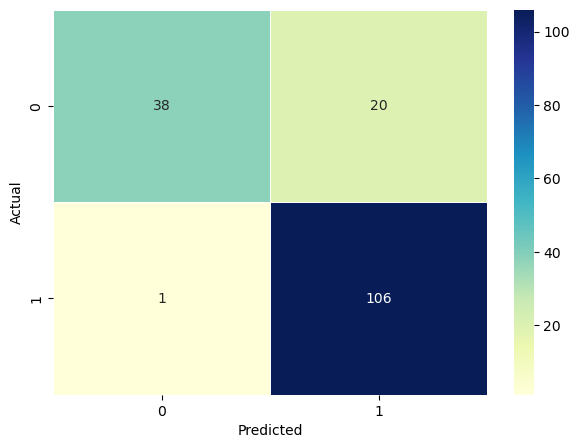

In [149]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)

# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [158]:
feature_cols = ["cool", "funny", "useful", "latitude", "longitude", "review_count"]
x_train_vectors_viet, x_test_vectors_viet = addFeatures(x_train_vectors_viet, x_test_vectors_viet,
                                             x_train_viet[feature_cols].to_numpy(), 
                                             x_test_viet[feature_cols].to_numpy())

MSE: 0.15151515151515152
R2-score: 0.3353206574282952
F1 score: 0.8196248196248197
Accuracy: 0.8484848484848485


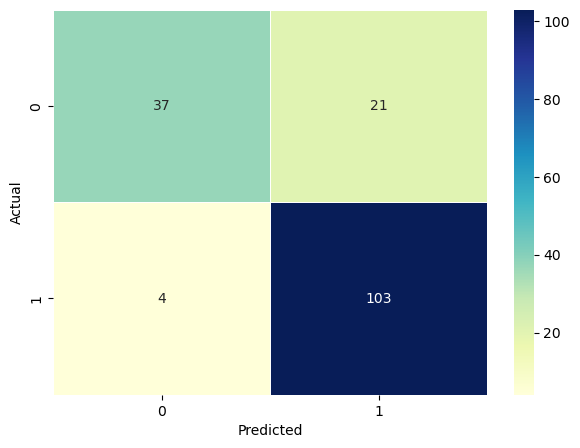

In [159]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)


# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

### 3.2.3 Geospatial analysis and visualisation of review data


### 3.2.4 Extra task 


In [71]:
def plot_top_words(model, feature_names, n_top_words, title, rows=2, columns=5):
    fig, axes = plt.subplots(rows, columns, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color='black')
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [72]:
# LDA uses raw term counts 
no_features=300
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(data.preprocessed_text)
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [113]:
# Run LDA
no_topics=3
lda = LatentDirichletAllocation(no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


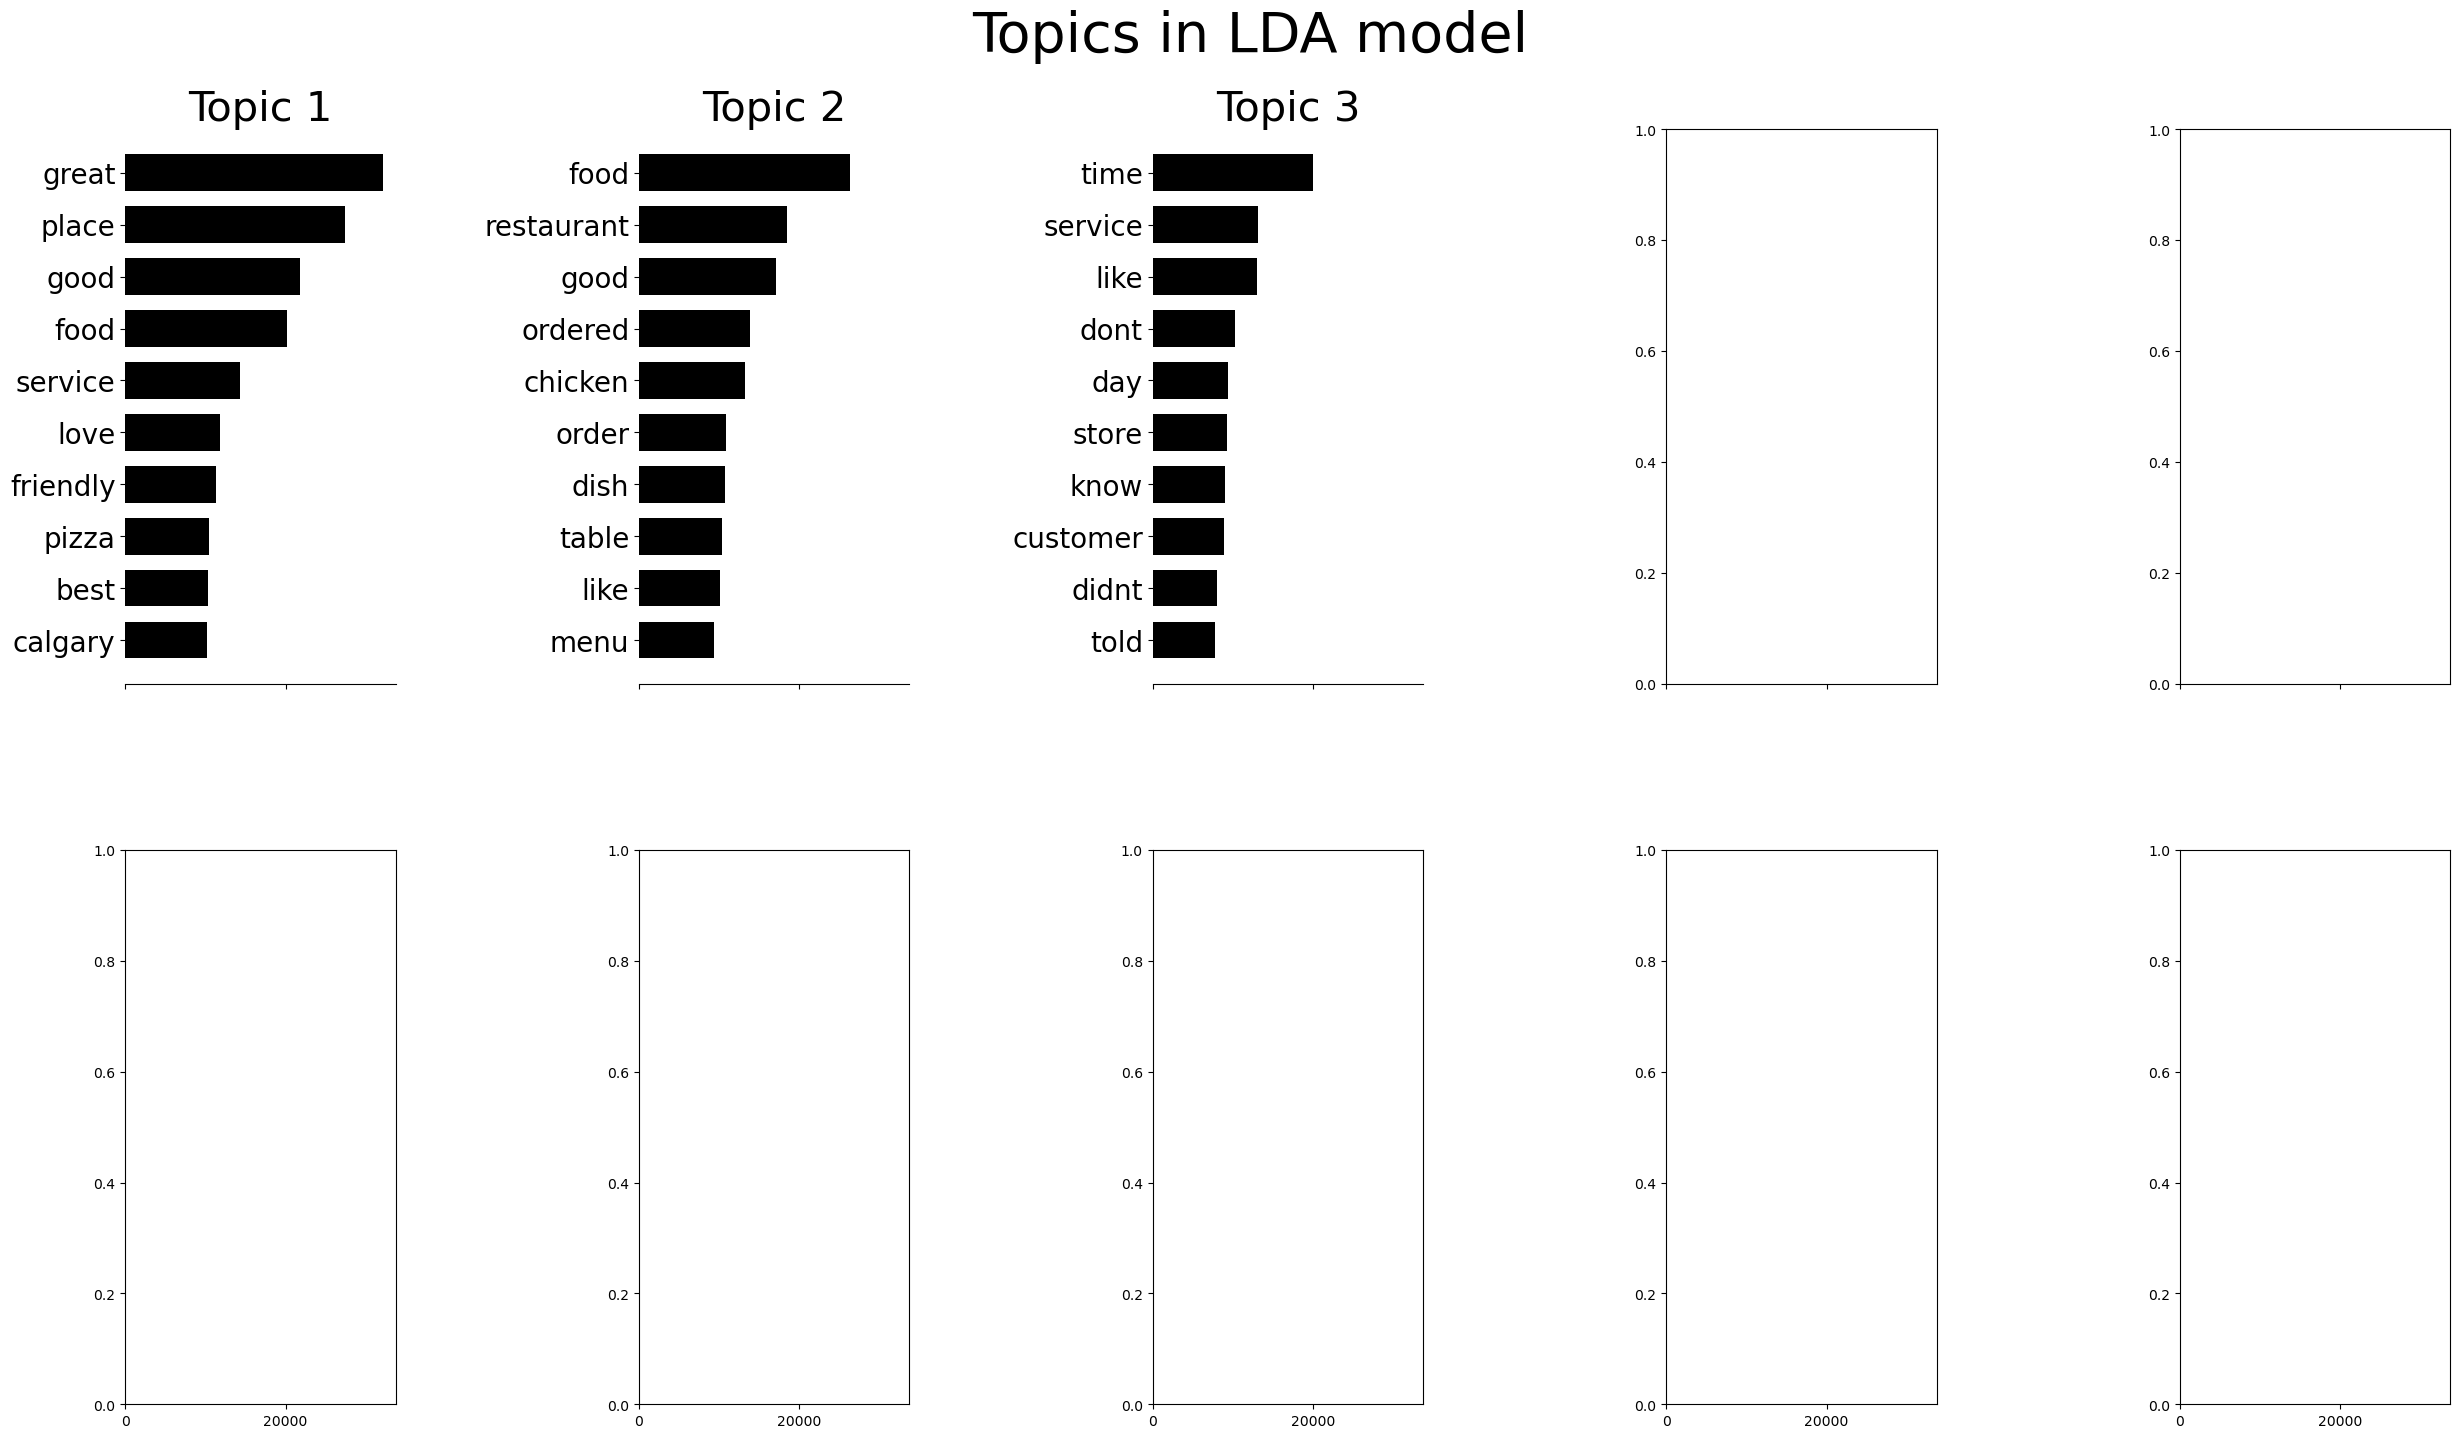

In [114]:
# plot top words
no_top_words = 10
plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')